In [1]:
# %matplotlib widget

import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf
import PandemiXModelFunctions as pmf

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.facecolor'] = (1,1,1,1)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)

import datetime
             
from scipy.integrate import cumtrapz
# int_I = cumtrapz(np.exp(u_H*ts)*Is,ts, initial=0)
# Hs = np.exp(-u_H*ts) * (r_chr*pars_full['gamma']*int_I + k) 

In [2]:
# Model with explicit symptomatic category and keeping track of whether recovered were found or not
modelMeta = ({
     'beta * S * (P+A)' : ['S','E1'],
     'gamma * E1' : ['E1','E2'],
     'gamma * E2' : ['E2','P'],
     'gamma * rho * P' : ['P','I'],
     'gamma * (1-rho) * P' : ['P','A'],
     'nu * A' : ['A',None],
     'nu * Q' : ['Q','Rp'],
     # 'nu * I' : ['I',None],
     'nu * I' : ['I','Rp'], # Assuming that symptomatic cases get tested, but aren't included in Q 
     'tau * E2' : ['E2','Q'],
     'tau * P'  : ['P','Q'],
     'tau * A'  : ['A','Q'],
     # 'tau * I'  : ['I','Q'], # Testing of symptomatic cases
     # 'tauInf * I'  : ['I','Q'], # Testing of symptomatic cases
     
},
['S','E1','E2','P','A','Q','I','Rp'],['beta','gamma','nu','rho','tau'])


In [118]:
# Initialize everything
iniExp = 100/5800000

# E1_0 = iniExp 
# E2_0 = 0
# P_0 = 0
E1_0 = iniExp
E2_0 = 0
P_0 = 0  
A_0 = 0 
I_0 = 0 
S_0 = 1 - E1_0 -E2_0 - P_0 - A_0-I_0

init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'P':P_0,'A':A_0,'Q':0,'I':I_0,'Rp':0}

gamma = 1/3
nu = 1/3
rho = 0.5
beta = 3*gamma
tau = 0.2
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}


tEnd = 500
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])

# changeTest = pmf.Change(10,SetParameters={})
# sch1.addChange(changeTest)

sch1.simulate(tRes=1000)

In [120]:
curSch = sch1 
ts = curSch.result.t
Rp = curSch.result.Rp
Rn = 1-curSch.result.y.sum(axis=0)

curInf = gamma * rho * curSch.result.P
curTest = tau * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A )
curTestAll = tau * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A + Rn)

curTestPos = tau*( curSch.result.E2+ curSch.result.P + curSch.result.A )

posPct = (curTestPos+curInf)/(curTestAll+curInf)

In [124]:
curSigma = sch1.result.S[-1]

In [121]:
def getBetaFromTauAndSigma(tau,sigma,pars):

    gamma = pars['gamma']
    nu = pars['nu']
    rho = pars['rho']

    estiTE = (1-sigma)/(gamma+tau)
    estiTP = (1-sigma - tau*estiTE)/(gamma+tau)
    estiTA = (1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau)

    beta = -np.log(sigma)/(estiTP+estiTA)
    

    return beta 

In [127]:
def calcFoundRatio(pars):
    gamma = pars['gamma']
    nu = pars['nu']
    rho = pars['rho']
    tau = pars['tau']

    # sigma = 0.19 
    # estiTE = (1-sigma)/(gamma+tau)
    # estiTP = (1-sigma - tau*estiTE)/(gamma+tau)
    # estiTA = (1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau)

    # toReturn = 1- (nu*estiTA)/(1-sigma)

    toReturn = 1 - (nu/(nu+tau))*(1-tau/(gamma+tau))*(1-(gamma*rho+tau)/(gamma+tau))
    return toReturn

# print(calcFoundRatio(newPars))
print(calcFoundRatio(pars))

0.9271030762501823


In [128]:
# betaRange = np.arange(0.1,3.1,0.1)*gamma 
tauRange = np.arange(0,0.31,0.05)

betaRange = [getBetaFromTauAndSigma(x,curSigma,pars) for x in tauRange]



C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12784/4289449675.py:21: RuntimeWarning: invalid value encountered in true_divide
  curRatio = Rp/(Rp+Rn)
C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12784/4289449675.py:24: RuntimeWarning: invalid value encountered in true_divide
  curRatioByTesting = countByTesting/Rp
C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12784/4289449675.py:21: RuntimeWarning: invalid value encountered in true_divide
  curRatio = Rp/(Rp+Rn)
C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12784/4289449675.py:24: RuntimeWarning: invalid value encountered in true_divide
  curRatioByTesting = countByTesting/Rp
C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12784/4289449675.py:21: RuntimeWarning: invalid value encountered in true_divide
  curRatio = Rp/(Rp+Rn)
C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12784/4289449675.py:24: RuntimeWarning: invalid value encountered in true_divide
  curRatioByTesting = countByTesting/Rp
C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12784/4

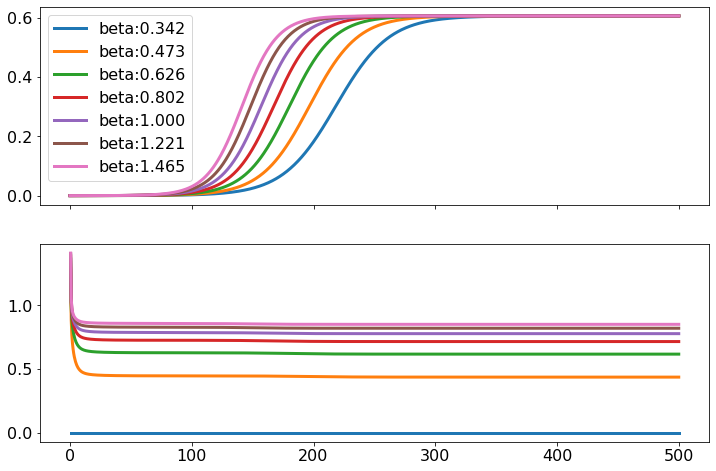

In [161]:

fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)

for i in range(len(tauRange)):

    tau = tauRange[i]
    # tau = 0.1
    beta = betaRange[i] 
    # beta = 1.1*gamma
    pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}

    curFound = calcFoundRatio(pars)

    tEnd = 500
    curSch = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])

    curSch.simulate(tRes=1000)
    
    ts = curSch.result.t
    Rp = curSch.result.Rp
    Rn = 1-curSch.result.y.sum(axis=0)
    curRatio = Rp/(Rp+Rn)

    countByTesting = cumtrapz(nu*(curSch.result.Q),ts,initial=0)
    curRatioByTesting = countByTesting/Rp

    ax1.plot(ts,Rp+Rn,label=f'beta:{beta:0.3f}')
    ax2.plot(ts,curRatioByTesting)

#     ax2.axhline(curFound,linestyle=':',color='k')

#     ax2.plot(ts,curRatio,label=f'beta:{beta:0.3f}')

# ax2.set_ylim([curFound*0.99,curFound*1.01])
# ax2.set_ylim([curFound*0.995,curFound*1.005])
# ax2.set_ylim([curRatioByTesting[-1]*0.8,curRatioByTesting[-1]*1.2])
ax1.legend()
# ax2.legend()

In [140]:
curSch = sch1 
ts = curSch.result.t
Rp = curSch.result.Rp
Rn = 1-curSch.result.y.sum(axis=0)

curInf = gamma * rho * curSch.result.P
curTest = tau * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A )
curTestAll = tau * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A + Rn)

curTestPos = tau*( curSch.result.E2+ curSch.result.P + curSch.result.A )


posPct = (curTestPos+curInf)/(curTestAll+curInf)

C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12784/3795179798.py:5: RuntimeWarning: invalid value encountered in true_divide
  curRatio = Rp/(Rp+Rn)


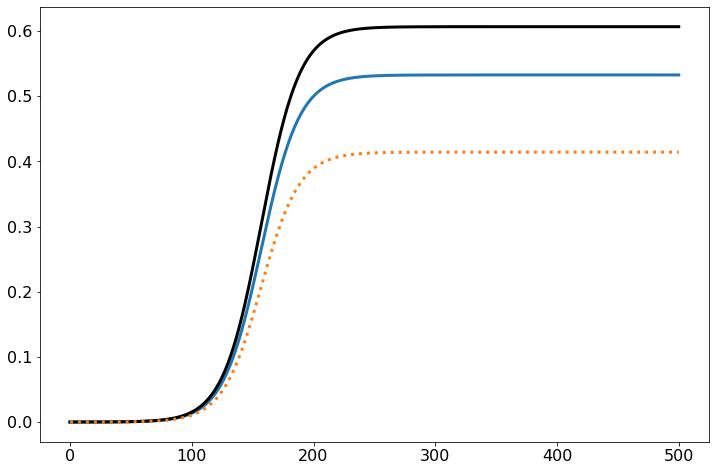

In [153]:
fig,ax1 = plt.subplots()
ax1.plot(ts,Rp)
ax1.plot(ts,Rp+Rn,'k')
ax1.plot(ts,cumtrapz(nu*(sch1.result.Q),ts,initial=0),':')
curRatio = Rp/(Rp+Rn)
# ax1.plot(ts,curRatio)

In [122]:
# fig,ax = plt.subplots()
# ax.plot(ts,sch1.result.E1)
# ax.plot(ts,sch1.result.E2)
# ax.plot(ts,sch1.result.I)
# ax.plot(ts,sch1.result.A)
# ax.plot(ts,sch1.result.P)
# ax.set_ylim([0,0.0005])

C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12784/2826896397.py:2: RuntimeWarning: invalid value encountered in true_divide
  curRatio = Rp/(Rp+Rn)


(0.0, 0.6370259894920302)

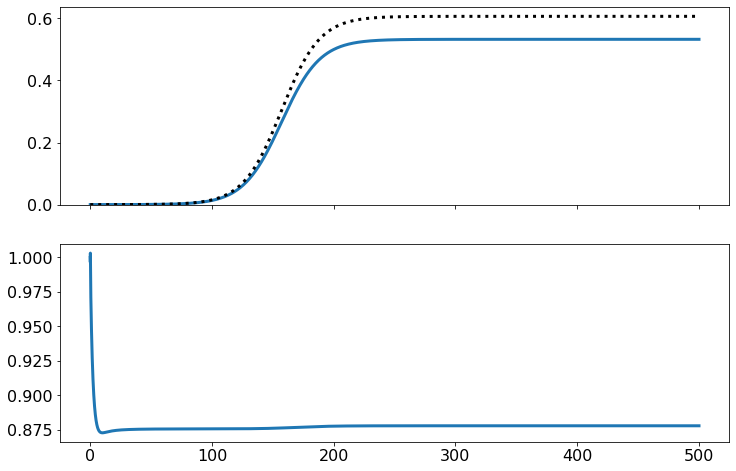

In [117]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
curRatio = Rp/(Rp+Rn)
ax1.plot(ts,Rp)
ax1.plot(ts,Rp+Rn,':k')
ax2.plot(ts,curRatio)

ax1.set_ylim(bottom=0)

# ax2.set_ylim([curRatio[-1]*0.995,curRatio[-1]*1.005])
# ax2.set_xlim([0,100])

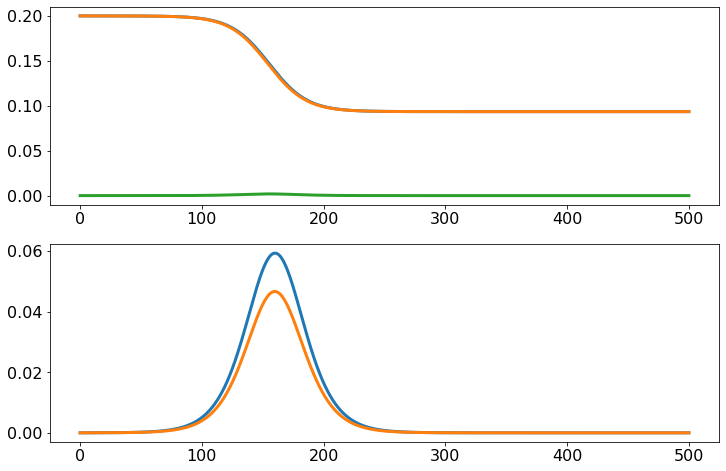

In [44]:
fig,(ax1,ax2) = plt.subplots(2,1)
ax1.plot(ts,curInf+curTestAll)
ax1.plot(ts,curTestAll)
ax1.plot(ts,curInf)

ax2.plot(ts,posPct)
ax2.plot(ts,curTestPos/curTestAll)

In [ ]:
curSch = sch1 
ts = curSch.result.t
Rp = curSch.result.Rp
Rn = 1-curSch.result.y.sum(axis=0)

curInf = gamma * rho * curSch.result.P
curTest = tau * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A )
curTestAll = tau * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A + Rn)

curTestPos = tau*( curSch.result.E2+ curSch.result.P + curSch.result.A )

posPct = (curTestPos+curInf)/(curTestAll+curInf)

In [23]:
betaRange = np.arange(0.1,3.1,0.1)*gamma 
tauRange = np.arange(0,0.31,0.05)

pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}

tEnd = 500
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])

sch1.simulate(tRes=1000)


array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ])